In [1]:
#---import libraries relating to data manipulation, visualization---------------------------------------------------
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json

#-------import libraries to evaluate the deep learning model---------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

#------ import Deep Learning Libraries-------#

import torch
import torch.nn as nn
import torch.optim as optim
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import pickle

import sys
sys.path.append('../../src')  # Add the 'src' directory to the path

#### Import Model Architecture
from multimodal.model_architecture import Generic1DCNN

#### Import Data Loading and Processing Functions<
from multimodal.helper_functions import reproducible_comp

reproducible_comp()


2023-11-07 16:32:47.939602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 16:32:47.939650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 16:32:47.939673: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 16:32:47.946432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 16:32:48.720014: W tensorflow/compiler/

In [2]:
file_path = "../../data/processed_data/press_in_df.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

In [3]:
labels_raw = data.iloc[:,0].copy()
features=data.iloc[:,1].values.reshape(-1,1).copy()
print("Features Shape: ", features.shape)
print("Labels Shape: ", labels_raw.shape)

Features Shape:  (360, 1)
Labels Shape:  (360,)


### Binary Labels

In [4]:
labels_bin = labels_raw.apply(lambda x: 0 if x == 'R' else 1)
labels_bin.head()

0    1
1    1
2    1
3    1
4    0
Name: category, dtype: int64

In [5]:
labels_bin.value_counts()

category
1    260
0    100
Name: count, dtype: int64

### 6 Labels (Multi Class)

In [6]:
# Create a dictionary for the mapping
mapping = {
    'W': 'Worn',
    'WP': 'Worn',
    'R': 'Referenz',
    'D': 'Dünn',
    'S': 'Slug',
    'SW': 'Slug-Worn',
    'SD': 'Slug-Dünn',
    'WD': 'Worn-Dünn',
    'SP': 'Slug',
    'SDP': 'Slug-Dünn',
    'WDP': 'Worn-Dünn',
    'SWP': 'Slug-Worn',
    'RV': 'Referenz',
    'WV': 'Worn',
    'SV': 'Slug',
    'SDV': 'Slug-Dünn',
    'WDV': 'Worn-Dünn',
    'SWV': 'Slug-Worn'
}


labels_six = labels_raw.map(mapping)

In [7]:
labels_six.unique()

array(['Worn', 'Referenz', 'Dünn', 'Slug', 'Slug-Worn', 'Slug-Dünn',
       'Worn-Dünn'], dtype=object)

### 4 Labels MultiLabel

In [8]:
labels_four_mlb = labels_six.str.split('-')
# Use MultiLabelBinarizer to create binary columns for multilabel classification
mlb = MultiLabelBinarizer()
labels_four_mlb = mlb.fit_transform(labels_four_mlb)
category_names = list(mlb.classes_)

In [9]:
category_names

['Dünn', 'Referenz', 'Slug', 'Worn']

In [10]:
labels_four_mlb.shape

(360, 4)

In [11]:
labels = labels_four_mlb.copy()
features = features.copy()
print("Features Shape: ", features.shape)
print("Labels Shape: ", labels.shape)

Features Shape:  (360, 1)
Labels Shape:  (360, 4)


In [12]:
max_length = 350
feat = np.array([np.pad(np.array(record), (0, max_length - len(record)), mode='constant', constant_values=(0)) for row in features for record in row])


print("Updated Features Shape: ", feat.shape)

Updated Features Shape:  (360, 350)


In [13]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/force/best_configs/force_press_in_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]
print(best_params)

{'lr': 0.006798446328113248, 'dropout_prob': 0.21155440170932938, 'hidden_channels': 149, 'n_layers': 3, 'kernel_size': 9, 'stride': 1, 'padding': 2, 'pooling_type': 'avg', 'use_batch_norm': True}


In [14]:
X_train = feat.reshape(-1, 1, feat.shape[1])
y_train = labels.copy()

print(X_train.shape)
print(y_train.shape)

(360, 1, 350)
(360, 4)


In [15]:
# Define the start, end, and interval
start = 0.95
end = 0.04
interval = -0.01

validation_sizes = [round(start + i * interval, 2) for i in range(int((end - start) / interval) + 1)]

In [16]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

# Convert your data to PyTorch tensors
x_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

input_channels = 1
num_classes = 4
n_layers = best_params["n_layers"]
kernel_size = best_params["kernel_size"]
stride = best_params["stride"]
padding = best_params["padding"]
hidden_channels = best_params["hidden_channels"]
dropout_prob = best_params["dropout_prob"]
pooling_type = best_params["pooling_type"]
use_batch_norm = best_params["use_batch_norm"]

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lists to store training and validation loss values and results for different training sizes
results = []

num_epochs = 50

for validation_size in validation_sizes:
    try:
        print(f"Training Size: {int((1-validation_size) * 100)}%")
        train_losses_iter = []  # Store training losses for this training size
        valid_losses_iter = []  # Store validation losses for this training size

        # Split the data into training and validation sets for this training size
        # Split the data into training and validation sets
        x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(
            x_train, y_train, test_size=validation_size, random_state=42
        )

        train_dataset = TensorDataset(x_train_split, y_train_split)
        valid_dataset = TensorDataset(x_valid_split, y_valid_split)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        model = Generic1DCNN(input_channels, num_classes, n_layers, kernel_size, stride, padding,
                             hidden_channels, dropout_prob, pooling_type, use_batch_norm).to(device)

        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            train_losses_iter.append(running_loss / len(train_loader))

            # Validation loss calculation (similar to training loop)
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for inputs_valid, labels_valid in valid_loader:
                    inputs_valid, labels_valid = inputs_valid.to(device), labels_valid.to(device)
                    outputs_valid = model(inputs_valid)
                    loss_valid = criterion(outputs_valid, labels_valid.float())
                    valid_loss += loss_valid.item()

            valid_losses_iter.append(valid_loss / len(valid_loader))

            if (epoch + 1) % 10 == 0:
                print(f"Training Size: {int((1-validation_size) * 100)}%, Epoch {epoch + 1}/{num_epochs}, "
                      f"Training Loss: {running_loss / len(train_loader)}, Validation Loss: {valid_loss / len(valid_loader)}")

        # Evaluation on the validation set for this training size
        model.eval()
        y_true_valid = []
        y_pred_valid = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.int()
                outputs = model(inputs)
                predicted = (outputs > 0).int()
                y_true_valid.append(labels.cpu().numpy())
                y_pred_valid.append(predicted.cpu().numpy())

        # Convert lists to NumPy arrays for calculations
        y_true_valid = np.array(y_true_valid[0]).reshape(-1, 4)
        y_pred_valid = np.array(y_pred_valid[0]).reshape(-1, 4)

        accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
        f1 = f1_score(y_true_valid, y_pred_valid, average='macro')

        results.append({
            "Training Size": int((1-validation_size) * 100),
            "Multi-label Validation Accuracy": accuracy,
            "F1 Score": f1
        })
        print(f"Accuracy: {accuracy}\n F1-Score: {f1}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Training Size: 5%
Training Size: 5%, Epoch 10/50, Training Loss: 0.5890451073646545, Validation Loss: 0.6105627616246542
Training Size: 5%, Epoch 20/50, Training Loss: 0.4068778157234192, Validation Loss: 0.4903361996014913
Training Size: 5%, Epoch 30/50, Training Loss: 0.2439296543598175, Validation Loss: 0.4101884911457698
Training Size: 5%, Epoch 40/50, Training Loss: 0.15430742502212524, Validation Loss: 0.4883431891600291
Training Size: 5%, Epoch 50/50, Training Loss: 0.1250586360692978, Validation Loss: 0.5189184794823328
Accuracy: 0.859375
 F1-Score: 0.7483541510978258
Training Size: 6%
Training Size: 6%, Epoch 10/50, Training Loss: 0.5994455218315125, Validation Loss: 0.606856087843577
Training Size: 6%, Epoch 20/50, Training Loss: 0.46603715419769287, Validation Loss: 0.48493512471516925
Training Size: 6%, Epoch 30/50, Training Loss: 0.3176744878292084, Validation Loss: 0.45105402668317157
Training Size: 6%, Epoch 40/50, Training Loss: 0.27063095569610596, Validation Loss: 0.4

In [17]:
# Print the results for different training sizes
for result in results:
    print(f"Training Size: {result['Training Size']}%, "
          f"Multi-label Validation Accuracy: {result['Multi-label Validation Accuracy'] * 100:.2f}%, "
          f"F1 Score: {result['F1 Score']:.2f}")

Training Size: 5%, Multi-label Validation Accuracy: 85.94%, F1 Score: 0.75
Training Size: 6%, Multi-label Validation Accuracy: 82.42%, F1 Score: 0.65
Training Size: 6%, Multi-label Validation Accuracy: 82.42%, F1 Score: 0.71
Training Size: 7%, Multi-label Validation Accuracy: 85.55%, F1 Score: 0.70
Training Size: 8%, Multi-label Validation Accuracy: 76.56%, F1 Score: 0.63
Training Size: 9%, Multi-label Validation Accuracy: 84.38%, F1 Score: 0.76
Training Size: 10%, Multi-label Validation Accuracy: 82.03%, F1 Score: 0.71
Training Size: 12%, Multi-label Validation Accuracy: 84.38%, F1 Score: 0.72
Training Size: 13%, Multi-label Validation Accuracy: 87.11%, F1 Score: 0.73
Training Size: 14%, Multi-label Validation Accuracy: 85.16%, F1 Score: 0.74
Training Size: 15%, Multi-label Validation Accuracy: 83.98%, F1 Score: 0.66
Training Size: 16%, Multi-label Validation Accuracy: 87.89%, F1 Score: 0.74
Training Size: 17%, Multi-label Validation Accuracy: 86.72%, F1 Score: 0.73
Training Size: 18%

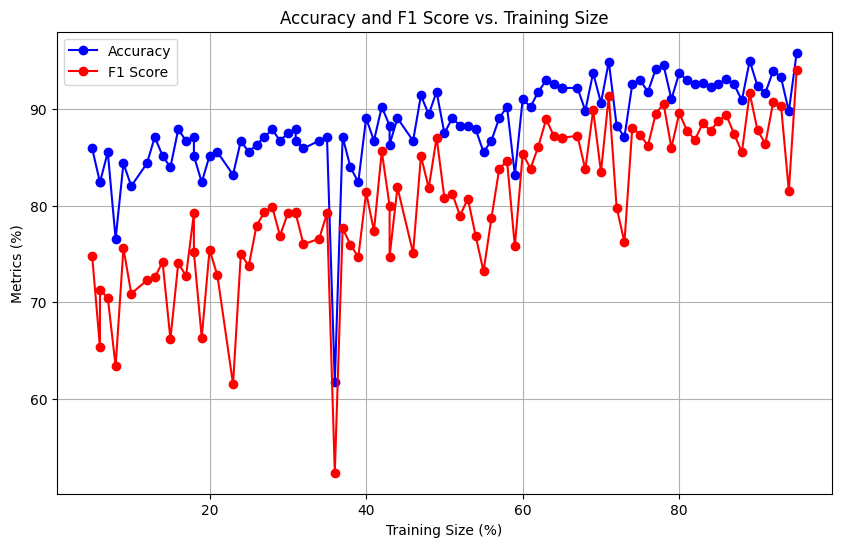

In [18]:
# Extract data for plotting
training_sizes = [result['Training Size'] for result in results]
accuracies = [result['Multi-label Validation Accuracy'] * 100 for result in results]
f1_scores = [result['F1 Score'] *100 for result in results]

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(training_sizes, accuracies, label='Accuracy', marker='o', linestyle='-', color='b')
plt.plot(training_sizes, f1_scores, label='F1 Score', marker='o', linestyle='-', color='r')

# Set axis labels and legend
plt.xlabel('Training Size (%)')
plt.ylabel('Metrics (%)')
plt.title('Accuracy and F1 Score vs. Training Size')
plt.legend()

# Show the plot
plt.grid()
plt.show()


# Thank You